In [6]:
import os
import tensorflow as tf
from keras import models
from keras import layers
from keras import Sequential
from datetime import datetime
from PIL import Image
import numpy as np
import keras.backend as K
import matplotlib.pyplot as plt
import mlflow
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot as plt
from keras.models import Model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, accuracy_score


In [7]:
dataset_name = "crop_dataset_2"
batch_size = 16

In [8]:
# tf.keras.mixed_precision.set_global_policy('mixed_float16')

In [10]:
# Load the dataset

image_size = (380, 380)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_name,
    validation_split=0.2,
    subset="training",
    label_mode = 'int',
    labels = 'inferred',
    seed=1336,
    image_size=image_size,
    interpolation = 'bilinear',
    batch_size=batch_size,
    shuffle = True,
)


val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_name,
    validation_split=0.2,
    subset="validation",
    label_mode = 'int',
    labels = 'inferred',
    seed=1336,
    image_size=image_size,
    interpolation = 'bilinear',
    batch_size=batch_size,
    shuffle = True,
)


Found 1864 files belonging to 7 classes.
Using 1492 files for training.
Found 1864 files belonging to 7 classes.
Using 372 files for validation.


In [11]:
class_names = train_ds.class_names
print(class_names)

['aca_bd', 'aca_md', 'aca_pd', 'nor', 'scc_bd', 'scc_md', 'scc_pd']


In [12]:
# Obtain the number of samples
num_train_samples = 0
for images, labels in train_ds:
    num_train_samples += images.shape[0]

num_val_samples = 0
for images, labels in val_ds:
    num_val_samples += images.shape[0]




In [13]:
# Print the dimensions of the training dataset
for images, labels in train_ds:
    print(images.shape)
    print(labels.shape)
    break

(16, 380, 380, 3)
(16,)


In [14]:
print("Number of training samples:", num_train_samples)
print("Number of validation samples:", num_val_samples)


Number of training samples: 1492
Number of validation samples: 372


In [15]:
# imput = (255,255,3)

Each EfficientNet variant has a specific input size requirement. Here are the input sizes for some popular EfficientNet models:

EfficientNetB0: (224, 224, 3)
EfficientNetB1: (240, 240, 3)
EfficientNetB2: (260, 260, 3)
EfficientNetB3: (300, 300, 3)
EfficientNetB4: (380, 380, 3)
EfficientNetB5: (456, 456, 3)
EfficientNetB6: (528, 528, 3)
EfficientNetB7: (600, 600, 3)
These sizes represent the input dimensions (height, width, number of channels) that the models expect. Therefore, when using any EfficientNet variant, you need to resize your images to match the corresponding input size before feeding them into the model.

In [17]:
base_model = EfficientNetB4(include_top = False ,weights='imagenet', pooling='avg')


# Introduce a layer of data augmentation
data_augmentation = Sequential([
   preprocessing.RandomRotation(0.2),
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomContrast(0.2),
    preprocessing.RandomTranslation(0.2, 0.2),    
])



# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the last 10 layers in the base model for fine-tuning

for layer in base_model.layers[-10:]:
    layer.trainable = True

#Capa de entradas. No se si eficientnet ya espera 225x225 o es 224 x 224. En realidad la efficient net ya tiene un parametro de input shape...
# Capa de entradas

entradas = layers.Input((380, 380, 3))

# Apply data augmentation to the input images
x = data_augmentation(entradas)


# Pass the augmented images through the base model
x = base_model(x)


# Add a dense layer
x = layers.Dense(512, activation='relu')(x)
# Add another dense layer
salidas = layers.Dense(7, activation='softmax')(x)

modelo = Model(inputs = entradas, outputs = salidas)

modelo.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
modelo.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 380, 380, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 380, 380, 3)       0         
_________________________________________________________________
efficientnetb4 (Functional)  (None, 1792)              17673823  
_________________________________________________________________
dense_2 (Dense)              (None, 512)               918016    
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 3591      
Total params: 18,595,430
Trainable params: 3,236,871
Non-trainable params: 15,358,559
_________________________________________________________________


In [18]:
num_params = modelo.count_params()
print("Number of parameters:", num_params)



Number of parameters: 18595430


In [19]:
folder_date = 'old_models/' +  datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p")
os.mkdir(folder_date)
filepath_model = folder_date + '/my_best_model.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5'


# Callbacks

In [20]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
filepath=filepath_model,
save_weights_only=False,
monitor='val_accuracy',
mode='max',
save_freq="epoch",
save_best_only=True)

In [21]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, mode='auto', verbose = 1, )

## Para hacer un training con weights

In [22]:

# # Calculate class weights
# # class_weights = tf.class_weight.compute_class_weight('balanced', tf.unique(train_ds.labels)[0], train_ds.labels)

# # Convert class weights to dictionary
# # class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

# # history = modelo.fit(
# #     train_ds, epochs=epochs, validation_data=val_ds, callbacks=[model_checkpoint_callback], class_weight=class_weights_dict
# # )

In [30]:
mlflow.end_run()


In [31]:
# Start an MLflow run
mlflow.start_run()

mlflow.set_experiment('scientific_data')

# Log the name of the dataset
mlflow.log_param("dataset_name", dataset_name)

# Log the number of samples in the dataset
#   mlflow.log_param("num_samples_train", num_train_samples)
#   mlflow.log_param("num_samples_train", num_val_samples)

tf.keras.backend.clear_session()


epochs = 60
history = modelo.fit(
    train_ds, epochs=epochs, validation_data=val_ds, callbacks=[model_checkpoint_callback]
)
 
# Evaluate the model
loss, accuracy = modelo.evaluate(val_ds)

#Logging


mlflow.log_param("epochs", epochs)
mlflow.log_param("batch_size", batch_size)

mlflow.log_param("parameters", num_params)

mlflow.log_metric("val_loss", loss)
mlflow.log_metric("val_accuracy", accuracy)




Epoch 1/60
94/94 [==============================] - 66s 678ms/step - loss: 0.6249 - accuracy: 0.7634 - val_loss: 0.6559 - val_accuracy: 0.7715
Epoch 2/60
94/94 [==============================] - 63s 670ms/step - loss: 0.5952 - accuracy: 0.7902 - val_loss: 0.7041 - val_accuracy: 0.7661
Epoch 3/60
94/94 [==============================] - 63s 668ms/step - loss: 0.5698 - accuracy: 0.7882 - val_loss: 0.8961 - val_accuracy: 0.7285
Epoch 4/60
94/94 [==============================] - 63s 668ms/step - loss: 0.5806 - accuracy: 0.7922 - val_loss: 0.6962 - val_accuracy: 0.7608
Epoch 5/60
94/94 [==============================] - 62s 657ms/step - loss: 0.5600 - accuracy: 0.7969 - val_loss: 0.8330 - val_accuracy: 0.7419
Epoch 6/60
94/94 [==============================] - 62s 658ms/step - loss: 0.5493 - accuracy: 0.7976 - val_loss: 0.7306 - val_accuracy: 0.7554
Epoch 7/60
94/94 [==============================] - 63s 666ms/step - loss: 0.5154 - accuracy: 0.8164 - val_loss: 0.6534 - val_accuracy: 0.7581

In [25]:
#Guardo el modelo en la última epoch. Esto 
modelo.save(folder_date + '/modelo_entrenado.h5')


In [26]:
history
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [27]:
folder_date + "/accuracy.png"

'old_models/2023_08_09-12_24_05_PM/accuracy.png'

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


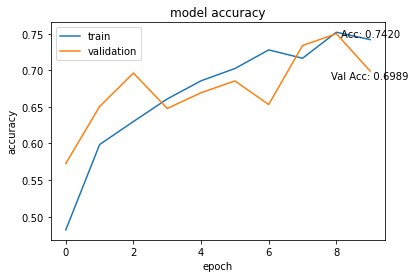

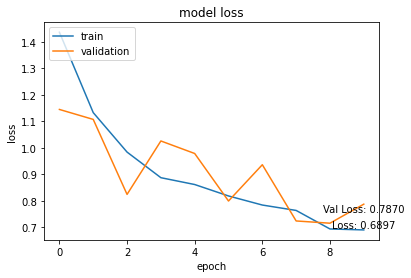

In [28]:
print(history.history.keys())

#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.text(len(history.history['accuracy'])-1, history.history['accuracy'][-1], 
         f"Acc: {history.history['accuracy'][-1]:.4f}", ha='center', va='bottom')
plt.text(len(history.history['val_accuracy'])-1, history.history['val_accuracy'][-1], 
         f"Val Acc: {history.history['val_accuracy'][-1]:.4f}", ha='center', va='top')


plt.savefig(folder_date + "/accuracy.png")
plt.show()

# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.text(len(history.history['loss'])-1, history.history['loss'][-1], 
         f"Loss: {history.history['loss'][-1]:.4f}", ha='center', va='bottom')
plt.text(len(history.history['val_loss'])-1, history.history['val_loss'][-1], 
         f"Val Loss: {history.history['val_loss'][-1]:.4f}", ha='center', va='top')


plt.savefig(folder_date + "/loss.png")
plt.show()





Preguntas, cómo puedo gestionar datos que vienen de dos distribuciones distintas?



# This is a section to evaluate the model on te test data

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 3, 1, 1, 1, 1, 1, 0, 0, 5, 3, 3, 2, 3, 2, 2, 2, 2, 3, 4, 4, 4, 2, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 0, 2, 3, 6, 3, 3, 3, 3, 4, 5, 4, 4, 4, 4, 4, 1, 4, 4, 5, 4, 1, 4, 4, 4, 0, 5, 6, 0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 5, 6, 6, 5, 6, 2, 6, 2, 6, 6, 6, 6]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]


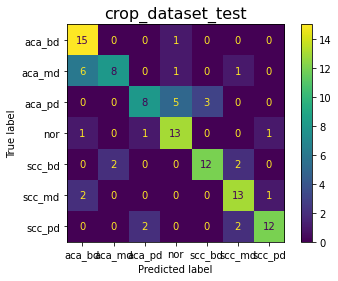

Precision: 0.7402339723768295
Recall: 0.7232142857142857
Accuracy: 0.7232142857142857


In [33]:
# Load the test images from the folder 'test_images'
predicted_labels= []
true_labels = []
directory = "crop_dataset_test"


label_mapping = {
    'aca_bd': 0,
    'aca_md': 1,
    'aca_pd': 2,
    'nor' : 3,
    'scc_bd' : 4,
    'scc_md' : 5, 
    'scc_pd' : 6
}


for filename in os.listdir(directory):

    # Load the image and add it to the list of test images
    f = os.path.join(directory, filename)
    imagen = tf.keras.preprocessing.image.load_img(f, target_size=(380,380))
    x = tf.keras.preprocessing.image.img_to_array(imagen)    
    x = np.expand_dims(x, axis=0)

    prediction = modelo.predict(x)
    predicted_class = np.argmax(prediction)

    #True labels are calculated based on name. It is a very weak way of doing it. Look for a better one or rename the files

    if 'aca_bd' in filename:
        true_labels.append(0)
    elif 'aca_md' in filename:
        true_labels.append(1)
    elif 'aca_pd' in filename:
        true_labels.append(2)
    elif 'nor' in filename:
        true_labels.append(3)
    elif 'scc_bd' in filename:
        true_labels.append(4)    
    elif 'scc_md' in filename:
        true_labels.append(5)
    elif 'scc_pd' in filename:
        true_labels.append(6)
    
    predicted_labels.append(predicted_class)

print(predicted_labels)
print(true_labels)


cm = confusion_matrix(true_labels, predicted_labels)
labels = [label for label, _ in sorted(label_mapping.items(), key=lambda x: x[1])]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()

plt.title(directory,  fontdict={'fontsize': 16})  # Set the new title for the plot
plt.show()


# Calculate precision, recall, and accuracy
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
accuracy = accuracy_score(true_labels, predicted_labels)

# Print the results
print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)

mlflow.log_metric("Precision", precision)
mlflow.log_metric("Recall", recall)
mlflow.log_metric("Accuracy", accuracy)

mlflow.end_run()

